# Handwritten Digit Recognizer

---

## Task Package 1: Data Preparation and Understanding

### 1.1 PIL and NumPy Basics

We start by building fluency with the two core libraries before touching MNIST.
PIL handles images as objects; NumPy handles them as numerical arrays.
The bridge is `np.array(pil_image)` and `Image.fromarray(np_array)`.

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# --- NumPy: the shapes we'll work with throughout the project ---

# A single flattened MNIST image will be a vector of 784 values (28*28)
sample_vector = np.zeros(784, dtype=np.float32)
print(f"Single image vector shape: {sample_vector.shape}")

# A batch of 60,000 training images will be a 2D matrix
batch = np.zeros((60000, 784), dtype=np.float32)
print(f"Full training set shape:   {batch.shape}")

# Normalization: pixel [0,255] → float [0.0, 1.0]
raw = np.array([0, 64, 128, 192, 255], dtype=np.uint8)
normalized = raw.astype(np.float32) / 255.0
print(f"\nRaw:        {raw}")
print(f"Normalized: {normalized}")

# One-hot encoding preview: label 3 → [0,0,0,1,0,0,0,0,0,0]
label = 3
one_hot = np.zeros(10, dtype=np.float32)
one_hot[label] = 1.0
print(f"\nLabel {label} one-hot: {one_hot}")

Single image vector shape: (784,)
Full training set shape:   (60000, 784)

Raw:        [  0  64 128 192 255]
Normalized: [0.        0.2509804 0.5019608 0.7529412 1.       ]

Label 3 one-hot: [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


### 1.2 Download MNIST and Visualize with PIL

MNIST is distributed in a custom binary format (IDX). We parse it manually
with Python's `struct` module, no sklearn or external loaders.

In [2]:
import sys
sys.path.insert(0, '../src')

from task1_data_prep import download_mnist, load_mnist_images, load_mnist_labels
from task1_data_prep import visualize_samples_with_pil, normalize_images

# Download (skips if already present)
download_mnist('../data/mnist')

# Load raw arrays
train_images_raw = load_mnist_images('../data/mnist/train-images-idx3-ubyte')
train_labels_raw = load_mnist_labels('../data/mnist/train-labels-idx1-ubyte')
test_images_raw  = load_mnist_images('../data/mnist/t10k-images-idx3-ubyte')
test_labels_raw  = load_mnist_labels('../data/mnist/t10k-labels-idx1-ubyte')

print(f"\nTraining images: {train_images_raw.shape}  dtype: {train_images_raw.dtype}")
print(f"Training labels: {train_labels_raw.shape}  dtype: {train_labels_raw.dtype}")
print(f"Test images:     {test_images_raw.shape}   dtype: {test_images_raw.dtype}")
print(f"Test labels:     {test_labels_raw.shape}   dtype: {test_labels_raw.dtype}")

Already exists: ../data/mnist\train-images-idx3-ubyte
Already exists: ../data/mnist\train-labels-idx1-ubyte
Already exists: ../data/mnist\t10k-images-idx3-ubyte
Already exists: ../data/mnist\t10k-labels-idx1-ubyte
Loaded images: (60000, 28, 28) | dtype: uint8
Loaded labels: (60000,) | dtype: uint8
Loaded images: (10000, 28, 28) | dtype: uint8
Loaded labels: (10000,) | dtype: uint8

Training images: (60000, 28, 28)  dtype: uint8
Training labels: (60000,)  dtype: uint8
Test images:     (10000, 28, 28)   dtype: uint8
Test labels:     (10000,)   dtype: uint8


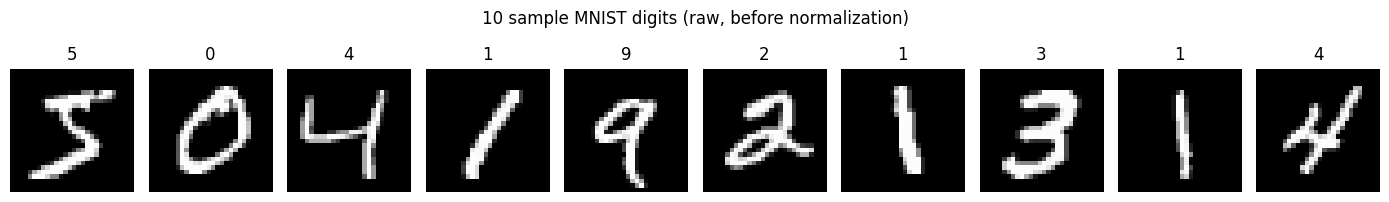

Normalized: min=0.000, max=1.000, mean=0.131
Normalized: min=0.000, max=1.000, mean=0.133


In [3]:
# Visualize 10 samples using PIL, then display in notebook
fig, axes = plt.subplots(1, 10, figsize=(14, 2))
for i in range(10):
    pil_img = Image.fromarray(train_images_raw[i], mode='L')
    axes[i].imshow(np.array(pil_img), cmap='gray')
    axes[i].set_title(str(train_labels_raw[i]))
    axes[i].axis('off')
plt.suptitle("10 sample MNIST digits (raw, before normalization)", y=1.02)
plt.tight_layout()
plt.show()

# Normalize
train_images_norm = normalize_images(train_images_raw)
test_images_norm  = normalize_images(test_images_raw)

### 1.3 Array Preparation and Train/Test Split

The network expects flat 1D input vectors and one-hot encoded label vectors.
MNIST already provides an official 60,000/10,000 split, we use it as-is.

In [4]:
from task1_data_prep import flatten_images, one_hot_encode, verify_split, plot_label_distribution

X_train = flatten_images(train_images_norm)
X_test  = flatten_images(test_images_norm)
y_train = one_hot_encode(train_labels_raw)
y_test  = one_hot_encode(test_labels_raw)

verify_split(X_train, y_train, X_test, y_test)

# Save for Task 2
np.save('../data/X_train.npy', X_train)
np.save('../data/y_train.npy', y_train)
np.save('../data/X_test.npy',  X_test)
np.save('../data/y_test.npy',  y_test)
print("\n✓ Arrays saved to data/ — ready for Task Package 2")

Flattened: (60000, 28, 28) → (60000, 784)
Flattened: (10000, 28, 28) → (10000, 784)
One-hot encoded: (60000,) → (60000, 10)
Example — label 5 → [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
One-hot encoded: (10000,) → (10000, 10)
Example — label 7 → [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]

Dataset Summary
X_train shape : (60000, 784)
y_train shape : (60000, 10)
X_test shape  : (10000, 784)
y_test shape  : (10000, 10)
X dtype       : float32
y dtype       : float32
X value range : [0.00, 1.00]
Label sample  : [5 0 4 1 9]

✓ Arrays saved to data/ — ready for Task Package 2


Saved plot to ../data/label_distribution.png


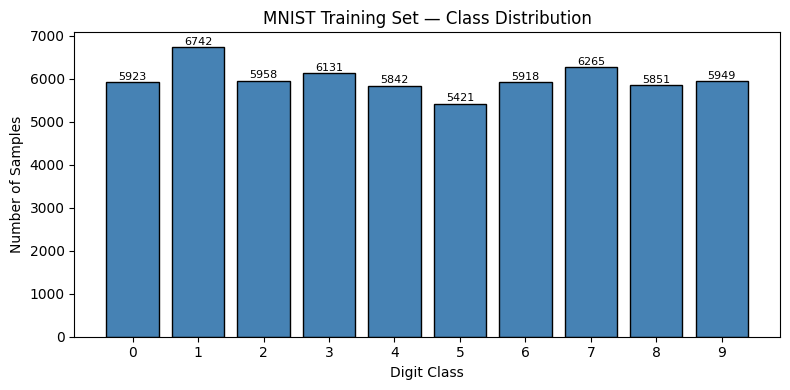

In [5]:
# Class distribution — verify the dataset is balanced
plot_label_distribution(train_labels_raw, title="MNIST Training Set — Class Distribution",
                        save_path="../data/label_distribution.png")

---

## Task Package 2: Neural Network Design and Implementation

### 2.1 Network Architecture

Architecture: 784 → 128 → 10

- Input layer: 784 neurons (one per pixel in the flattened 28×28 image)
- Hidden layer: 128 neurons (learns intermediate features like edges and curves)
- Output layer: 10 neurons (one per digit class 0–9)

Sigmoid activation is used throughout and it maps any real number to (0, 1).

In [6]:
import sys
sys.path.insert(0, '../src')

import numpy as np
from task2_neural_network import sigmoid, sigmoid_derivative, initialize_parameters

# Demonstrate sigmoid behavior
z = np.array([-5, -2, -1, 0, 1, 2, 5], dtype=np.float32)
a = sigmoid(z)
print("z values:        ", z)
print("sigmoid(z):      ", np.round(a, 4))
print("sigmoid'(a):     ", np.round(sigmoid_derivative(a), 4))

# Initialize network parameters
params = initialize_parameters()

z values:         [-5. -2. -1.  0.  1.  2.  5.]
sigmoid(z):       [0.0067 0.1192 0.2689 0.5    0.7311 0.8808 0.9933]
sigmoid'(a):      [0.0066 0.105  0.1966 0.25   0.1966 0.105  0.0066]
Parameter shapes:
  W1: (128, 784)
  b1: (128, 1)
  W2: (10, 128)
  b2: (10, 1)


### 2.2 Parameter Initialization, Learning Rate, Loss Function

Weights are initialized with small random values (×0.01) to break symmetry
while keeping sigmoid inputs near zero. Biases start at zero.
Learning rate: 0.1 —> controls the step size during gradient descent.
Loss function: binary cross-entropy —> works cleanly with sigmoid outputs.

In [7]:
from task2_neural_network import compute_loss

# Load data
X_train = np.load('../data/X_train.npy')
y_train = np.load('../data/y_train.npy')
y_train_int = np.argmax(y_train, axis=1)

# Use a small subset for this demo
X_sub = X_train[:1000]
y_sub = y_train[:1000]

# Forward pass with random weights — loss should be ≈ 2.3 (random guessing)
from task2_neural_network import forward_pass
A2, cache = forward_pass(X_sub, params)

loss = compute_loss(A2, y_sub)
print(f"Initial loss with random weights: {loss:.4f}  (expected ≈ 2.3)")
print(f"Output shape: {A2.shape}")
print(f"Output range: [{A2.min():.4f}, {A2.max():.4f}]")

Initial loss with random weights: 0.6956  (expected ≈ 2.3)
Output shape: (1000, 10)
Output range: [0.4856, 0.5241]


### 2.3 Forward Pass and Backpropagation

Forward pass: data flows left to right through weighted sums and sigmoid activations.
Backpropagation: error flows right to left using the chain rule to compute gradients.
Gradient descent: each weight is nudged slightly in the direction that reduces the loss.

Parameter shapes:
  W1: (128, 784)
  b1: (128, 1)
  W2: (10, 128)
  b2: (10, 1)
Epoch   0 | Loss: 0.6956 | Accuracy: 11.7%
Epoch  10 | Loss: 0.3245 | Accuracy: 11.7%
Epoch  20 | Loss: 0.3243 | Accuracy: 11.7%
Epoch  30 | Loss: 0.3240 | Accuracy: 11.7%
Epoch  40 | Loss: 0.3238 | Accuracy: 12.9%


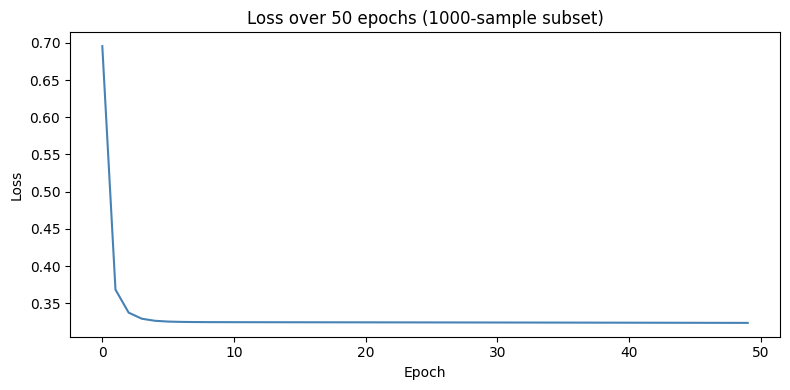

In [8]:
from task2_neural_network import backpropagation, update_parameters, compute_accuracy

# Run 50 epochs on the subset to verify learning
params = initialize_parameters()
losses = []

for epoch in range(50):
    A2, cache = forward_pass(X_sub, params)
    loss = compute_loss(A2, y_sub)
    losses.append(loss)
    grads = backpropagation(y_sub, params, cache)
    params = update_parameters(params, grads)

    if epoch % 10 == 0:
        acc = compute_accuracy(X_sub, y_train_int[:1000], params)
        print(f"Epoch {epoch:3d} | Loss: {loss:.4f} | Accuracy: {acc*100:.1f}%")

# Plot the loss curve
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(losses, color='steelblue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over 50 epochs (1000-sample subset)")
plt.tight_layout()
plt.show()